In [1]:
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
import os
import shutil
import math
import io
from google.cloud import vision
import re
from collections import defaultdict
%matplotlib inline

def show(im):
    plt.figure(figsize=(10,10))
    plt.imshow(im)

def try_except(method):
    def func(*args, **kw):
        try:
            result = method(*args, **kw)
        except Exception as e:
            result = None
#             print(method.__name__ ," failed")
        return result
    return func


In [2]:
def google_hit(img_file):
    '''Fetches the response from the google cloud API'''

    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/connect/Downloads/ML-TFT.json"
    client = vision.ImageAnnotatorClient()

    with io.open(img_file, 'rb') as image_file:
        content = image_file.read()

        image = vision.types.Image(content=content)
    # response = client.document_text_detection(image=image, image_context={"language_hints": ["en"]})
    response = client.document_text_detection(image=image,image_context={"language_hints": ["en"]})
    document = response.full_text_annotation

    return document, response

  
def find_word_location(document,word_to_find):
    word_list = []
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    assembled_word=assemble_word(word)
                    if(assembled_word.lower()==word_to_find.lower()):
                        word_list.append(word.bounding_box.vertices) 
    return word_list

def assemble_word(word):
    assembled_word = ""
    for symbol in word.symbols:
        assembled_word += symbol.text
    return assembled_word



def text_within(document,bbox):
    '''finds out the text within a set of co-ordinates'''
    x1,y1,x2,y2 = bbox
   
    symbols = []
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        min_x=min(symbol.bounding_box.vertices[0].x,symbol.bounding_box.vertices[1].x,symbol.bounding_box.vertices[2].x,symbol.bounding_box.vertices[3].x)
                        max_x=max(symbol.bounding_box.vertices[0].x,symbol.bounding_box.vertices[1].x,symbol.bounding_box.vertices[2].x,symbol.bounding_box.vertices[3].x)
                        min_y=min(symbol.bounding_box.vertices[0].y,symbol.bounding_box.vertices[1].y,symbol.bounding_box.vertices[2].y,symbol.bounding_box.vertices[3].y)
                        max_y=max(symbol.bounding_box.vertices[0].y,symbol.bounding_box.vertices[1].y,symbol.bounding_box.vertices[2].y,symbol.bounding_box.vertices[3].y)
                        if(min_x >= x1 and max_x <= x2 and min_y >= y1 and max_y <= y2):
                            symbols.append([symbol,min_x,min_y,max_x,max_y])
                            
    df = pd.DataFrame(symbols)
    
    df = df.sort_values([2,1])
    df[2]=df[2].astype(int)
    y_list = sorted( df[2].unique())
    lines = []
    old_y = -y_list[0]
    tol = 7
    for y in y_list:
        text=""
        if old_y+tol< y :
            df_ = df[(df[2]>=y)&(df[2]<=y+tol)]
            df_ = df_.sort_values(1)
            old_y =y
            
            for symbol in df_[0]:
                text+=symbol.text
                if(symbol.property.detected_break.type==1 or symbol.property.detected_break.type==3):
                    text+=' '
                if(symbol.property.detected_break.type==2):
                    text+='\t'
                if(symbol.property.detected_break.type==5):
                    text+='\n'
            lines.append(text.lower())
    return lines


In [3]:
@try_except
def find_regex(text, pattern, out_pattern='\d*',join=True):
    text = text.lower()
    ans = re.findall(pattern, text)[0]
    print(ans)
    ans = re.findall(out_pattern ,ans)
    ans = [each for each in ans if len(each)>0]
    if join:
        ans = ''.join(ans[0].split())
    else:
        ans = ans[0][len(pattern)-1:]
    return ans.strip()

In [4]:
@try_except
def find_string_location(words):
    all_boxes = []
    for each in words:
        boxes = find_word_location(document, each)
        boxes = [[each, box[0].x,box[0].y,box[2].x,box[2].y] for box in boxes]
        all_boxes.extend(boxes)
    all_boxes = pd.DataFrame(all_boxes)
    for y in all_boxes[2].unique().tolist():
        all_boxes_ =   all_boxes[(all_boxes[2]>=y-2) & (all_boxes[2]<=y+2)]
        if all_boxes_[0].nunique()==len(words):
            final = all_boxes_
            break
    final = final.sort_values(by=1)
    return final.iloc[0][1], final.iloc[0][2], final.iloc[-1][3], final.iloc[-1][4]

In [5]:
@try_except
def estimated_fetal(list1, list2):
    lines = return_table(list1, list2)
    lines = [each for each in lines if not 'version' in each]
    temp = ' '.join(lines).replace('\n',' ').replace('  ',' ')
    if ':' in temp:
        temp = temp.split(':')[1].strip()
    else:
        temp = re.findall('\d.*',temp)[0]
    return temp 

In [6]:
@try_except
def return_table(heading_string_list_1,heading_string_list_2):
    second_coor = find_string_location(heading_string_list_2)
     
    first_coor = find_string_location(heading_string_list_1)
     
    df =  text_within(document, [0,first_coor[3],W,second_coor[1]])
    return df

In [7]:
def process_ga_row(temp_text, key): 
    d = {}
    temp_text = temp_text.replace('\n',' ').replace('  ',' ')
    try:
        d[key] = re.findall('[0-9]*.[0-9]* cm',temp_text)[0]
    except:
        pass
    try:
        d[key+'_age'] = re.findall('[0-9o]*w[0-9o]*d',temp_text)[0]
    except:
        pass
    try:
        d[key+'_range'] = re.findall('\+\/\-[0-9o]*d',temp_text)[0]
    except:
        pass
    
    return d

In [8]:
# @try_except
def process_ga_table(list1=['gestational','age'], list2=['ratios']):
    table_ga = {}
    lines = return_table(list1, list2)
    for l in lines:
        if 'bpd' in l:
            table_ga.update(process_ga_row(l, 'hadlock_bpd'))
        if 'hc' in l:
            table_ga.update(process_ga_row(l, 'hadlock_hcty'))
        if 'ac' in l:
            table_ga.update(process_ga_row(l, 'hadlock_ac'))
        if 'fl' in l:
            table_ga.update(process_ga_row(l, 'hadlock_fl'))
        if 'humerus' in l:
            table_ga.update(process_ga_row(l, 'jeanty_humerus'))
        if 'ofd' in l:
            table_ga.update(process_ga_row(l, 'hansmann_ofd'))
    return table_ga

In [9]:
def process_ratio_table(list1=['ratios'],list2=['basic','measurements']):
    table_ratio = {}
    lines = return_table(list1, list2)
    for l in lines:
        if 'hc' in l and 'ac' in l:
            ans = re.findall(r'[0-9\.\(\)\- ]*',l)
            table_ratio['hc_ac'] = [each for each in ans if len(each)>0][0].strip()
        if 'fl' in l and 'ac' in l:
            ans = re.findall(r'[0-9\.\(\)\- ]*',l)
            table_ratio['fl_ac'] = [each for each in ans if len(each)>0][0].strip()
        if 'bpd' in l and 'fl' in l:
            ans = re.findall(r'[0-9\.\(\)\- ]*',l)
            table_ratio['fl_bpd'] = [each for each in ans if len(each)>0][0].strip()
        if 'bpd' in l and 'ofd' in l:
            ans = re.findall(r'[0-9\.\(\)\- ]*',l)
            table_ratio['ci_bpd_ofd'] = [each for each in ans if len(each)>0][0].strip()
    return table_ratio

In [10]:
def get_headings():
    headings = []
    if find_string_location(['study','id']):
        headings.append('study id')
    if find_string_location(['name']):
        headings.append('name')
    if find_string_location(['average','ultrasound']):
        headings.append('average ultrasound')
    if find_string_location(['estimated','fetal']):
        headings.append('estimated fetal')
    if find_string_location(['gestational','age']):
        headings.append('gestational age')
    if find_string_location(['ratios']):
        headings.append('ratios')
    if find_string_location(['basic','measurements']):
        headings.append('basic measurements')
    if find_string_location(['cranium','measurements']):
        headings.append('cranium measurements')
    if find_string_location(['long','bone','measurements']):
        headings.append('long bone measurements')
    if find_string_location(['mmode','measurements']):
        headings.append('mmode measurements')
    if find_string_location(['calculations']):
        headings.append('calculations')
    if find_string_location(['anatomy','visualized']):
        headings.append('anatomy visualized')
    if find_string_location(['obstetric','findings']):
        headings.append('obstetric findings')
    if find_string_location(['interpretation','summary']):
        headings.append('interpretation summary')
    if find_string_location(['comments']):
        headings.append('comments')
    if find_string_location(['reading','physician']):
        headings.append('reading physician')
    return headings

In [11]:
def process_measure_row(temp_text, key):
    temp_text = temp_text.replace('\n',' ').replace('  ',' ').replace('*','')
    d = {}
    try:
        d[key] = re.findall('[0-9]*.[0-9]* [cm]m',temp_text)[0]
    except:
        pass
    try:
        d[key+'_range_avg'] = re.findall('[cm]m[a-z ]*',temp_text)[0].replace('cm','').replace('mm','')
    except:
        pass
    try:
        d[key+'_percentile'] = re.findall('[0-9\.]*%',temp_text)[0]
    except:
        pass
    
    try:
        n = temp_text.split('%')
        if not len(n)>1:
            n = temp_text.split('cm')
            if not len(n)>1:
                n = temp_text.split('mm')
        n = n[-1]
        n = re.findall('[0-9\. ]*',n)
        n = [each for each in n if len(each)>0]
        n = n[0].split()
        for i in range(len(n)):
            d[key+'_'+str(i+1)] = n[i]
    except:
        pass
    
    return d

In [12]:
# @try_except
def process_basic_measure_table(list1=['basic','measurements'], list2=['cranium','measurements']):
    table_measure = {}
    lines = return_table(list1, list2)
    for l in lines:
        l = l.replace('\n',' ').replace('  ',' ')
        if 'bpd' in l:
            table_measure.update(process_measure_row(l, 'bpd'))
        if 'hc' in l:
            table_measure.update(process_measure_row(l, 'hc'))
        if 'ac' in l:
            table_measure.update(process_measure_row(l, 'ac'))
        if 'fl' in l:
            table_measure.update(process_measure_row(l, 'fl'))
        
    return table_measure

In [13]:
def process_mmode_row(temp_text, key):
    temp_text = temp_text.replace('\n',' ').replace('  ',' ')
    d = {}
    try:
        d[key+'_calc'] = re.findall('[0-9]*.[0-9]* cm',temp_text)[0]
    except:
        pass
    
    try:
        n = re.findall('cm[0-9\. ]*',temp_text)
        for i in range(len(n)):
            d[key+'_'+str(i+1)] = n[i].split('cm')[1]
    except:
        pass
    
    return d

In [14]:
# @try_except
def process_mmode_table(list1=['mmode','measurements'], list2=['calculations']):
    table_mmode = {}
    lines = return_table(list1, list2)
    for l in lines:
        if 'cervix' in l:
            table_mmode.update(process_mmode_row(l, 'cervix_l'))
        if 'vertical' in l:
            table_mmode.update(process_mmode_row(l, 'max_vertical_pocket'))
        
    return table_mmode

In [15]:
def process_calculation_table(list1=['calculations'],list2=['anatomy','visualized']):
    lines = return_table(list1,list2)
    table_cal = {}
    for l in lines:
        l = l.replace('\n',' ').replace('  ',' ')
        if 'beat' in l:
            table_cal['fetal_heart_pk_to_pk'] = re.search('[0-9\. ]*sec',l).group(0).strip()
        if 'hr' in l:
            table_cal['fetal_heart_rate'] = re.search('[0-9\. ]*bpm',l).group(0).strip()
    return table_cal

In [16]:
def process_cranium_table(list1=['cranium','measurements'],list2=['long','bone','measurements']):
    table_measure = {}
    lines = return_table(list1, list2)
    for l in lines:
        if 'cerebellum' in l:
            table_measure.update(process_measure_row(l, 'cerebellum'))
        if 'ofd' in l:
            table_measure.update(process_measure_row(l, 'ofd'))
        if 'cist mag' in l:
            table_measure.update(process_measure_row(l, 'cistmag'))
        if 'ventricle' in l:
            table_measure.update(process_measure_row(l, 'lat'))
        if 'nuchal' in l:
            table_measure.update(process_measure_row(l, 'nuchal'))
        
    return table_measure

In [17]:
def process_long_bone_table(list1=['long','bone','measurements'],list2=['mmode','measurements']):
    table_measure = {}
    lines = return_table(list1, list2)
    for l in lines:
        if 'humerus' in l:
            table_measure.update(process_measure_row(l, 'longbone_humerus'))
        
    return table_measure

In [18]:
@try_except
def process_text(list1=['comments'], list2=['reading','physician']):
    lines = return_table(list1, list2)
    lines = [each for each in lines if not 'version' in each]
    temp = ' '.join(lines).replace('\n',' ').replace('✓','').replace('  ',' ')
    return temp 

In [19]:
def pad(img):
    h,w = img.shape[:2]
    return np.pad(img, ((0,max_h-h), (0,max_w-w), (0,0)), 'constant', constant_values=(0, 0) )

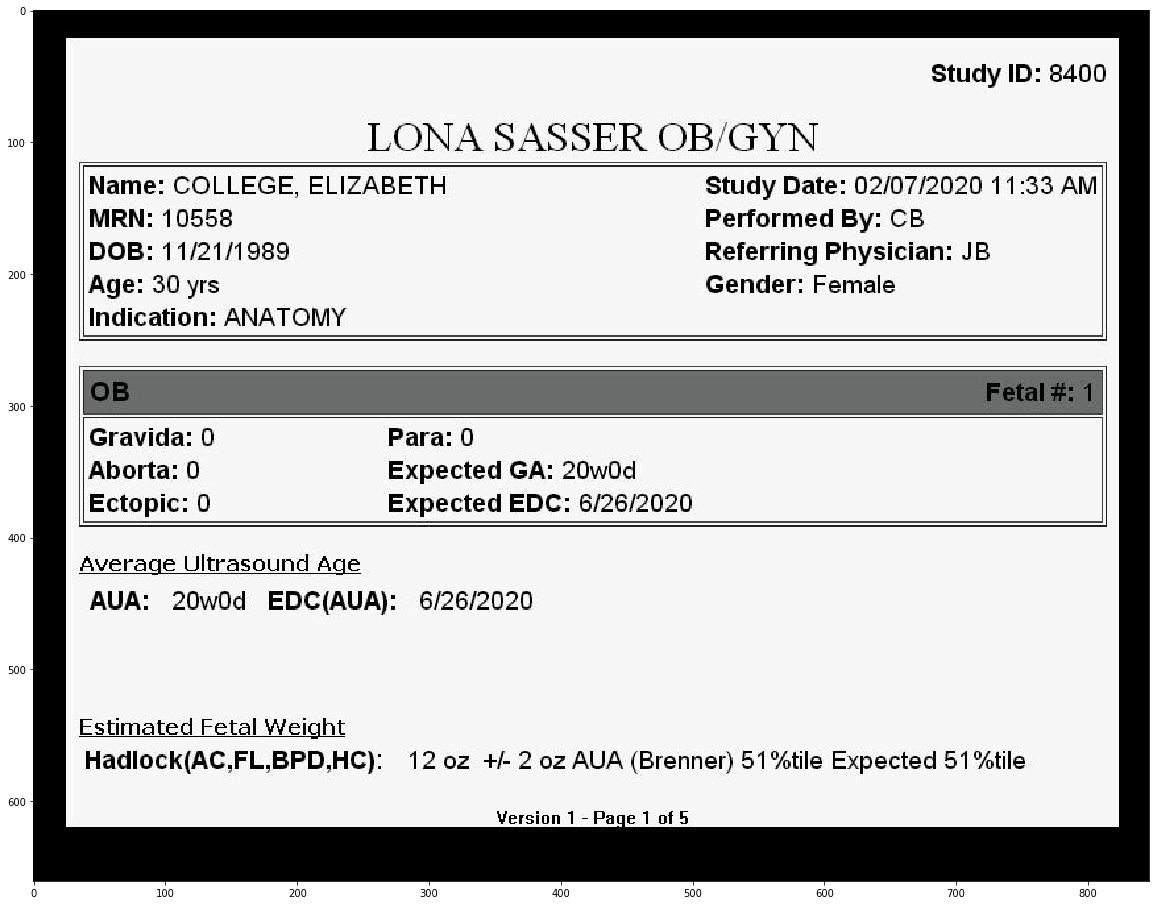

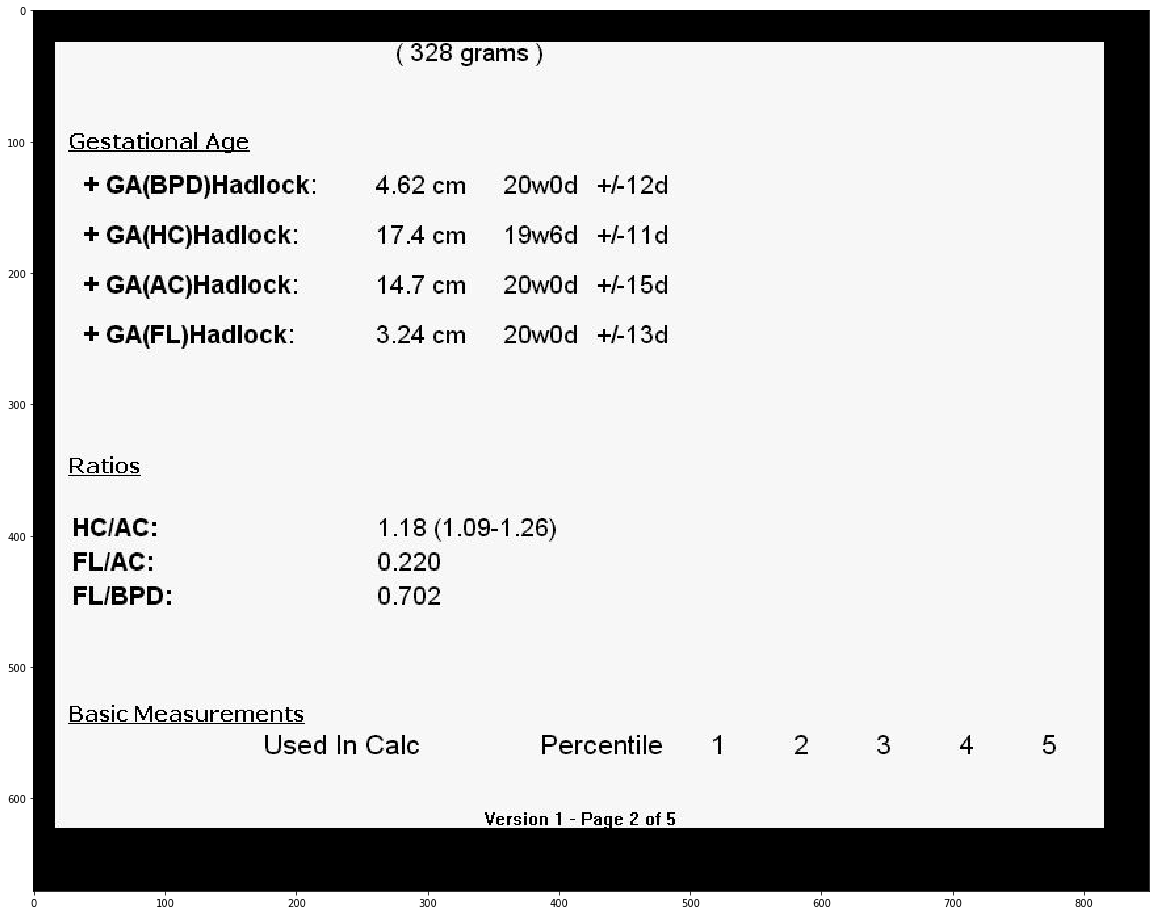

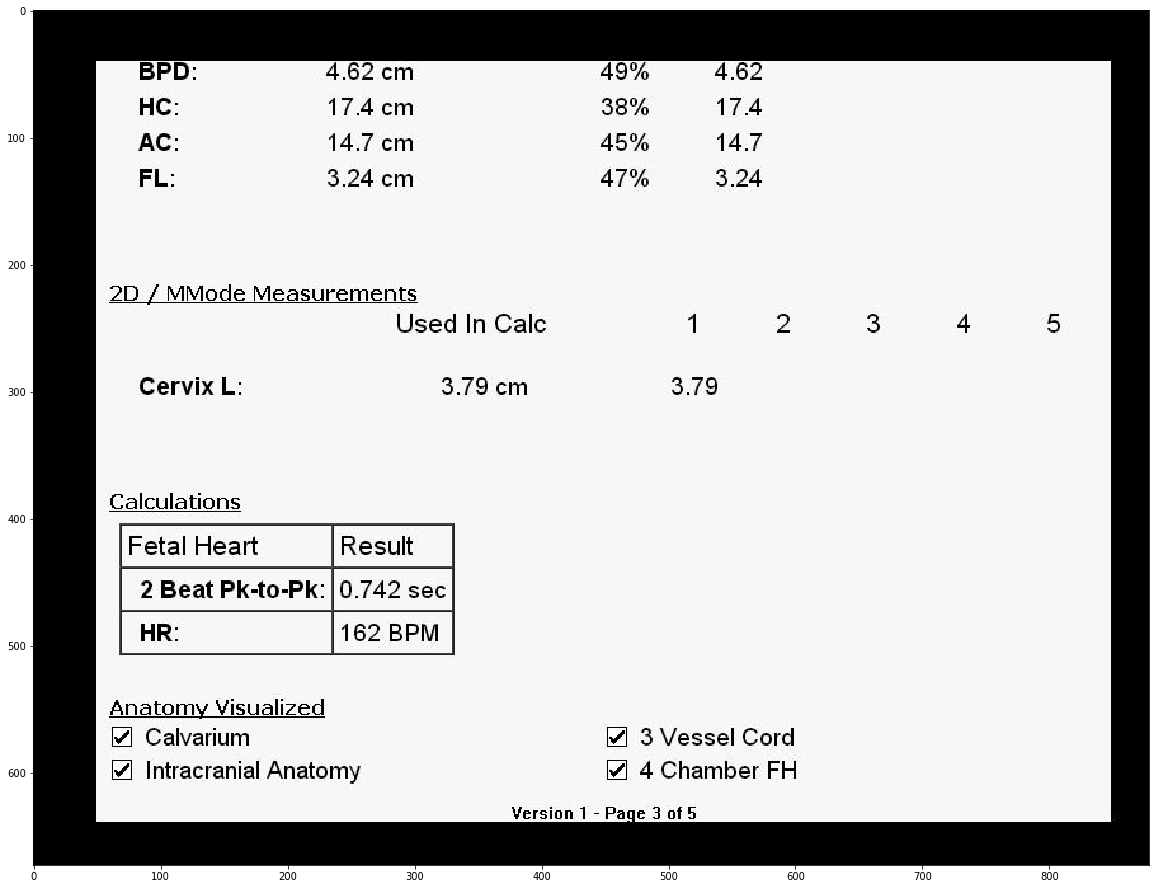

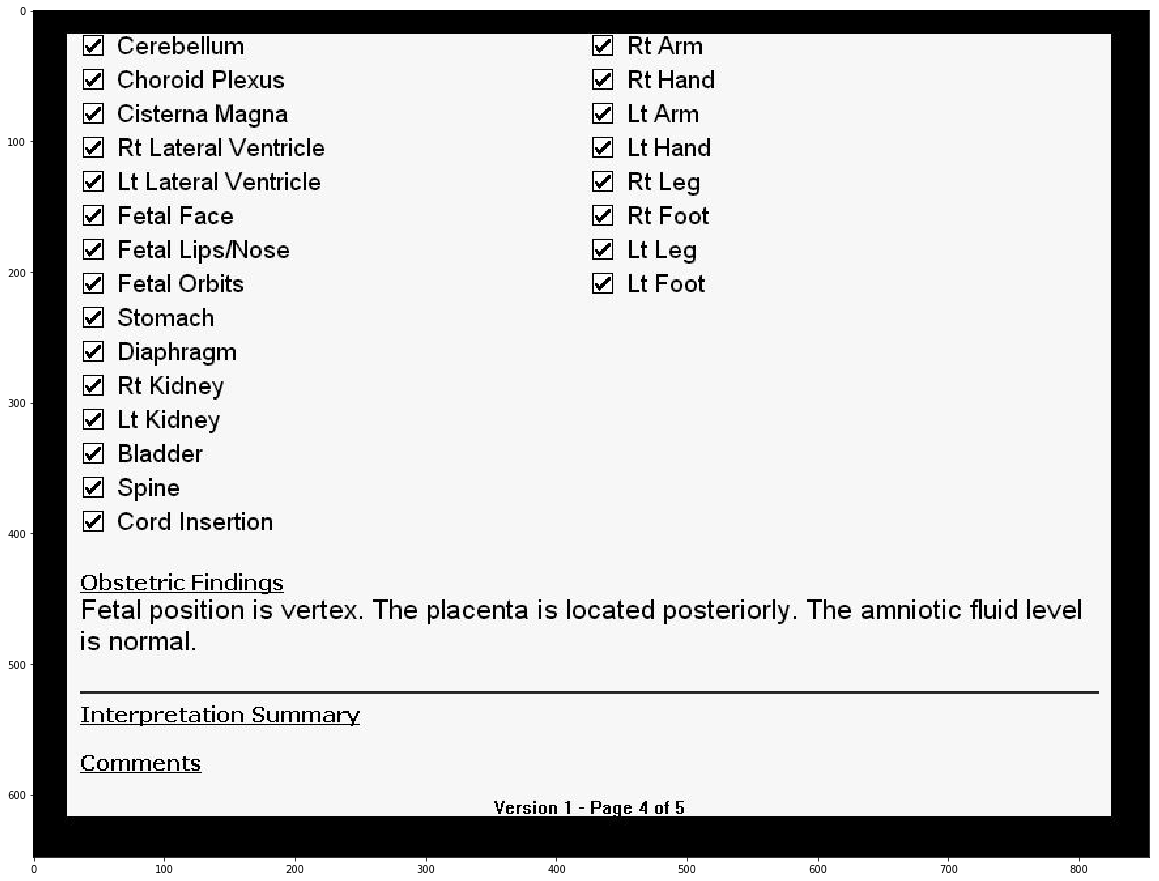

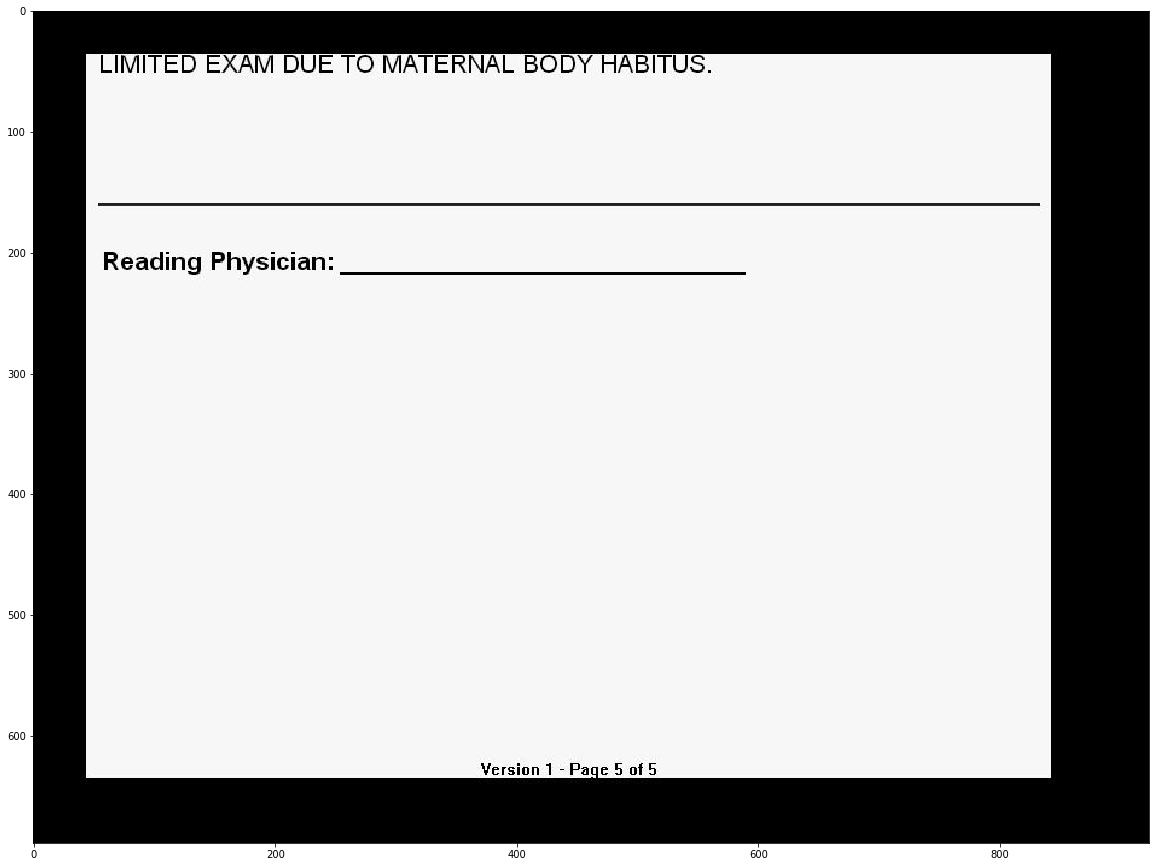

In [40]:
from matplotlib import pyplot as plt
%matplotlib inline
imgs = glob.glob('/home/connect/prashant/vision_api/images/8400-*')
imgs.remove('/home/connect/prashant/vision_api/images/8400-_merged.png')
imgs = sorted(imgs)
for each in imgs:
    each = cv2.imread(each)
    plt.figure(figsize=(20,20))
    plt.imshow(each)
    plt.show()

In [34]:
merged = cv2.imread('/home/connect/prashant/vision_api/images/8400-_merged.png')

H,W = merged.shape[:2]
document,response = google_hit('/home/connect/prashant/vision_api/images/8400-_merged.png')

In [35]:
text = document.text.lower()

In [38]:
output_dict = {}

headings = get_headings()
try:
    output_dict['id'] = int(find_regex(text,'study id.*','[0-9]*',))
except:
    pass
try:
    i = headings.index('study id')
    output_dict['ocr_template_name'] = return_table(headings[i].split(), headings[i+1].split())[0]
except:
    pass
try:
    output_dict['mrn'] = find_regex(text,'mrn.*','[0-9]*')
except:
    pass
try:
    output_dict['dob'] = datetime.strptime(find_regex(text,'dob.*','[0-9/]*'), '%m/%d/%Y')
except:
    pass
try:
    output_dict['age'] = float(find_regex(text,'age.*','[0-9]*'))
except:
    pass
try:
    output_dict['indication'] = find_regex(text,'indication.*','.*',join=False)
except:
    pass
try:
    output_dict['study_date'] = datetime.strptime(find_regex(text,'study date.*','[0-9/]+ [0-9]+:[0-9]+ [ap]m'), '%m/%d/%Y %I:%M %p')
except:
    pass
try:
    output_dict['performed_by'] = find_regex(text,'performed by.*','.*',join=False)
except:
    pass
try:
    output_dict['ref_phy'] = find_regex(text,'referring physician.*','.*',join=False)
except:
    pass
try:
    output_dict['gender'] = find_regex(text,'gender.*','.*',join=False)
except:
    pass
try:
    output_dict['last_men_period'] = datetime.strptime(find_regex(text,'lmp.*','[0-9/]*'),'%m/%d/%Y')
except:
    pass

try:
    output_dict['ges_age'] = find_regex(text,'ga.*','[0-9o]*w[0-9o]*d')
except:
    pass

try:
    output_dict['edc'] = datetime.strptime(find_regex(text,'edc.*','[0-9/]*'),'%m/%d/%Y')
except:
    pass
try:
    output_dict['ectopic'] = int(find_regex(text,'ectopic.*','[0-9]*'))
except:
    pass
try:
    output_dict['gravida'] = int(find_regex(text,'gravida.*','[0-9]*'))
except:
    pass
try:
    output_dict['para'] = int(find_regex(text,'para.*','[0-9]*'))
except:
    pass
try:
    output_dict['aborta'] = int(find_regex(text,'aborta.*','[0-9]*'))
except:
    pass

try:
    output_dict['average_us_age'] = find_regex(text,'aua.*[0-9o]*w[0-9o]*d*','[0-9o]*w[0-9o]*d*')
except:
    pass
try:
    output_dict['edc_aua'] = datetime.strptime(find_regex(text,'edc.*aua.*[0-9/]*','[0-9/]*'),'%m/%d/%Y')
except:
    pass
try:
    i = headings.index('estimated fetal')
    output_dict['hadlock_ac_fl_bpd_hc'] = estimated_fetal(headings[i].split(), headings[i+1].split())
except:
    pass

try:
    i = headings.index('gestational age')
    output_dict.update(process_ga_table(headings[i].split(), headings[i+1].split()))
except:
    pass

try:
    i = headings.index('ratios')
    output_dict.update(process_ratio_table( headings[i].split(), headings[i+1].split()))
except:
    pass

try:
    i = headings.index('basic measurements')
    output_dict.update(process_basic_measure_table( headings[i].split(), headings[i+1].split()))
except:
    pass

try:
    i = headings.index('cranium measurements')
    output_dict.update(process_cranium_table( headings[i].split(), headings[i+1].split()))
except:
    pass

try:
    i = headings.index('long bone measurements')
    output_dict.update(process_long_bone_table( headings[i].split(), headings[i+1].split()))
except:
    pass

try:
    i = headings.index('mmode measurements')
    output_dict.update(process_mmode_table( headings[i].split(), headings[i+1].split()))
except:
    pass

try:
    i = headings.index('calculations')
    output_dict.update(process_calculation_table( headings[i].split(), headings[i+1].split()))
except:
    pass

try:
    i = headings.index('interpretation summary')
    output_dict['interpretation_summary'] = process_text( headings[i].split(), headings[i+1].split())
except:
    pass

try:
    i = headings.index('comments')
    output_dict['comments'] = process_text( headings[i].split(), headings[i+1].split())
except:
    pass

study id: 8400
mrn: 10558
age: 30 yrs
indication: anatomy
performed by: cb
referring physician: jb
gender: female
ga: 20wod
ectopic: 0
gravida: 0
para: 0
aborta: 0
aua: 20wod


In [39]:
output_dict

{'aborta': 0,
 'ac': '14.7 cm',
 'ac_1': '14.7',
 'ac_percentile': '45%',
 'ac_range_avg': ' ',
 'age': 30.0,
 'average_us_age': '20wod',
 'bpd': '4.62 cm',
 'bpd_1': '4.62',
 'bpd_percentile': '49%',
 'bpd_range_avg': ' ',
 'cervix_l_1': ' 3.79 ',
 'cervix_l_calc': '3.79 cm',
 'comments': 'limited exam due to maternal body habitus. ',
 'ectopic': 0,
 'fetal_heart_pk_to_pk': '0.742 sec',
 'fetal_heart_rate': '162 bpm',
 'fl': '3.24 cm',
 'fl_1': '3.24',
 'fl_ac': '0.220',
 'fl_bpd': '0.702',
 'fl_percentile': '47%',
 'fl_range_avg': ' ',
 'gender': 'female',
 'ges_age': '20wod',
 'gravida': 0,
 'hadlock_ac': '14.7 cm',
 'hadlock_ac_age': '20wod',
 'hadlock_ac_fl_bpd_hc': '12 oz +/- 2 oz aua (brenner) 51%tile expected 51%tile (328 grams)',
 'hadlock_ac_range': '+/-15d',
 'hadlock_bpd': '4.62 cm',
 'hadlock_bpd_age': '20wod',
 'hadlock_bpd_range': '+/-12d',
 'hadlock_fl': '3.24 cm',
 'hadlock_fl_age': '20wod',
 'hadlock_fl_range': '+/-13d',
 'hadlock_hcty': '17.4 cm',
 'hadlock_hcty_age'

In [116]:
import pymysql
db = 'OCR_OB'
table = 'ocr_ob'
conn = pymysql.connect(host="localhost", user="root", password="root")
cursor= conn.cursor()

/home/connect/.local/lib/python3.5/site-packages/pymysql/cursors.py:170: Warning: (1008, "Can't drop database 'OCR_OB'; database doesn't exist")
  result = self._query(query)


0

In [2]:
def parse_sql(filename):
    data = open(filename, 'r').readlines()
    stmts = []
    DELIMITER = ';'
    stmt = ''

    for lineno, line in enumerate(data):
        if not line.strip():
            continue

        if line.startswith('--'):
            continue

        if 'DELIMITER' in line:
            DELIMITER = line.split()[1]
            continue

        if (DELIMITER not in line):
            stmt += line.replace(DELIMITER, ';')
            continue

        if stmt:
            stmt += line
            stmts.append(stmt.strip())
            stmt = ''
        else:
            stmts.append(line.strip())
    return stmts

In [4]:
if initialize_db:
    cursor.execute('drop database if exists OCR_OB')
    cursor.execute('create database OCR_OB')
    cursor.execute('use OCR_OB')
    stmts = parse_sql('/home/connect/prashant/vision_api/ocr_ob.sql')
    for stmt in stmts:
        cursor.execute(stmt)
else:
    cursor.execute('use OCR_OB')

In [28]:
placeholders = ', '.join(['%s'] * len(output_dict))
columns = ', '.join(output_dict.keys())
sql = "INSERT INTO %s ( %s ) VALUES ( %s )" % (table, columns, placeholders)
cursor.execute(sql, list(output_dict.values()))
conn.commit()
cursor.close()
conn.close()

1